In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unidecode
import re
from spacy.cli import download
import spacy
import nltk
import contractions

spacy.cli.download("en_core_web_sm")
nltk.download('stopwords')

from nltk.corpus import stopwords

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.3 MB/s  0:00:01 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /home/tguyot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv', encoding='latin1')

# Clean up Unnamed columns and change column names for clarity
df = df.assign(
    is_spam=lambda x: 0
)
df.loc[df.v1 == 'ham', 'is_spam'] = 1
df = df[['is_spam', 'v2']]
df.columns = ['is_spam', 'sms']


Text(0.5, 1.0, 'Proportion of spam and non-spam')

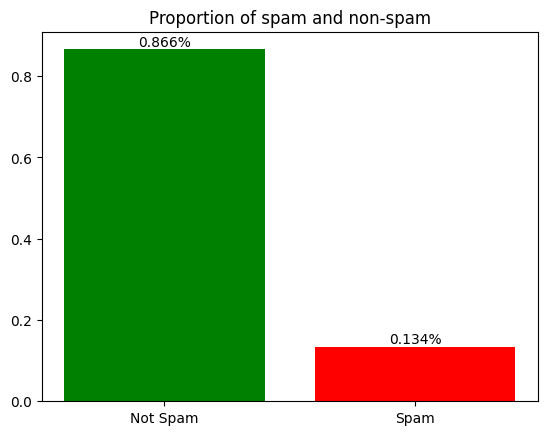

In [3]:
# Small EDA
fig, ax = plt.subplots()

container = ax.bar(['Not Spam', 'Spam'], df.is_spam.value_counts(normalize=True).values, color=['green', 'red'])
ax.bar_label(container, fmt='{:.3f}%')
ax.set_title('Proportion of spam and non-spam')


In [4]:
df.isna().sum() # no NaNs

is_spam    0
sms        0
dtype: int64

In [5]:
df_eda = df.copy()
df_eda['length'] = df_eda.sms.str.len()

spams = df_eda.loc[df_eda['is_spam'] == 0]
hams = df_eda.loc[df_eda['is_spam'] == 1]
spams.length.value_counts()

length
159    39
158    35
156    34
160    34
157    31
       ..
177     1
169     1
44      1
119     1
85      1
Name: count, Length: 122, dtype: int64

Text(0.5, 1.0, 'Distribution of spam and non-spam per length')

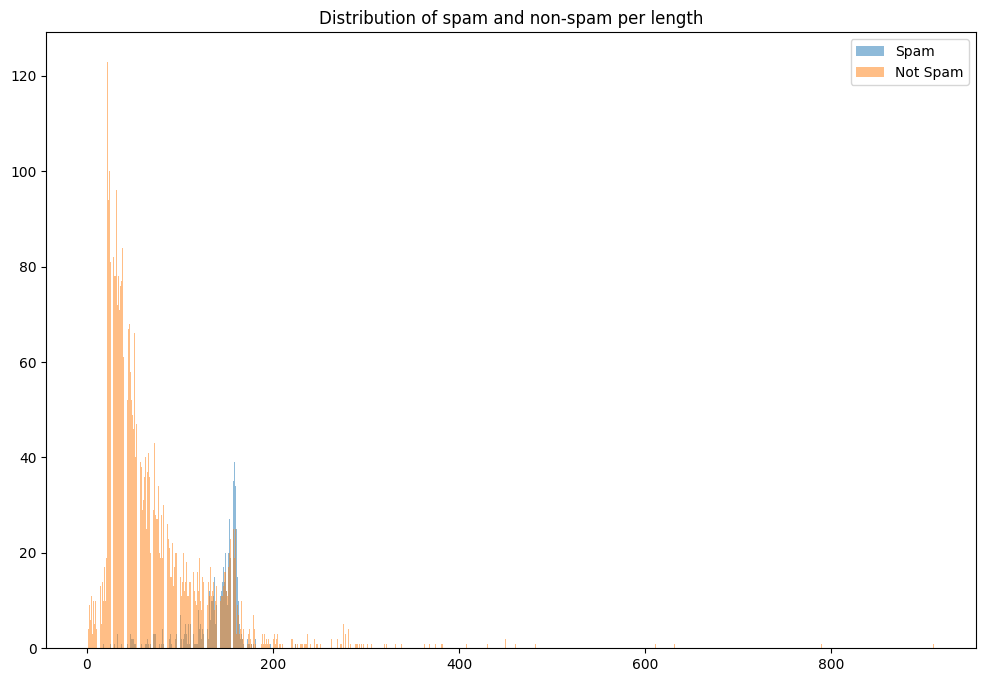

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(spams.length.value_counts().index, spams.length.value_counts().values, alpha=0.5 , label='Spam')
ax.bar(hams.length.value_counts().index, hams.length.value_counts().values, alpha=0.5, label='Not Spam')
ax.legend()
ax.set_title('Distribution of spam and non-spam per length')

In [7]:
# Data cleaning

    # Remplacer toutes les majuscules par des minuscules
    # Retirer les accents (étape très utile pour les textes français)
    # Retirer la ponctuation
    # Retirer les nombres (seulement si ceux-ci n’apportent pas d’informations pour l’analyse qui suivra !!! Dans notre problème binaire, les nombres semblent apporter de l’information (comme les numéros de téléphone); on va les remplacer par “phonenumber”).
    # Lemmatizer
    # Enlever les “stop words”
    # Supprimer les lignes vides 

# Uniform capitalization

df_clean = df.copy()

df_clean.sms = df_clean.sms.str.lower()

# Replace accents
df_clean.sms = df_clean.sms.apply(lambda x: unidecode.unidecode(x))

# Remove punctuation
df_clean.sms = df_clean.sms.apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_clean.sms = df_clean.sms.apply(lambda x: re.sub(r'_', '', x))

# Remove numbers
df_clean.sms = df_clean.sms.apply(lambda x: re.sub(r'\d', '', x))


In [8]:
# Lemmatize

# Need to download en_core_web_sm model if not already done
spacy.cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")
def to_lemma(text):
    doc = nlp(u'{}'.format(text))
    lemmatized_version = ''
    for token in doc:
        lemmatized_version += token.lemma_ + ' '
    return lemmatized_version

df_clean.sms = df_clean.sms.apply(
    lambda x: to_lemma(x)
)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.3 MB/s  0:00:01 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Remove "stop words": words not bringing information, in same high frequency everywhere

stop_words = set(stopwords.words('english'))
df_clean.sms = df_clean.sms.apply(lambda x: ' '.join([char for char in x.split() if char not in stop_words]))

In [10]:
# Contractions fix (don't into do not etc...)
df_clean.sms = df_clean.sms.apply(lambda x: contractions.fix(x))

# Synonyms ?

In [11]:
# Remove blank messages

df_clean = df_clean.loc[df_clean.sms.map(len) > 0]

In [12]:
df_clean.to_csv('cleaned_spam.csv')